# Pneumonia Detection

In [ ]:
!pip install kaggle
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import shutil
import os

TRAIN_PATH = "/content/drive/MyDrive/tesis/pruebat/prueba/train"
VAL_PATH = "/content/drive/MyDrive/tesis/pruebat/prueba/val"
VAL_SIZE = 0.2
labels = ['BAC_PNEUMONIA', 'NORMAL', 'VIR_PNEUMONIA']
train_bac = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[0])+'/*.jpeg'))
train_normal = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[1])+'/*.jpeg'))
train_viral = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[2])+'/*.jpeg'))

rng = np.random.RandomState(42)
rng.shuffle(train_bac)
rng.shuffle(train_normal)
rng.shuffle(train_viral)

for i, train_files in enumerate([train_bac, train_normal, train_viral]):
  val_split = int(len(train_files)*VAL_SIZE)
  train_files = train_files[:val_split]
  for train_file in train_files:
    file_path = os.path.join(VAL_PATH, labels[i])
    shutil.move(train_file, file_path)


## Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_image():
    TRAINING_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/train"
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        fill_mode="nearest",
        horizontal_flip=True,
        vertical_flip=True,
    )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224, 224),
        batch_size=64,
        class_mode="categorical",
        color_mode='rgb',
    )

    VALIDATION_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/val"
    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224, 224),
        batch_size=16,
        class_mode="categorical",
        color_mode='rgb',
    )

    return train_generator, validation_generator


## Modeling with InceptionResNetV2

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Input
from tensorflow import keras
import tensorflow as tf

conv_base = InceptionResNetV2(include_top=False, weights='imagenet',
                              input_shape=(224,224,3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block8_1_conv':
        set_trainable = True
    layer.trainable = set_trainable

inputs = Input(shape=(224,224,3))

x = layers.Conv2D(3, (3,3), padding='same')(inputs)

x = conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=L2(0.1))(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=[keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC(name='auc'),
                       keras.metrics.CategoricalAccuracy(name='acc')])


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_407 (Conv2D)             │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 5, 5, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 38400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     9,830,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,168,247 (244.78 MB)

 Trainable params: 32,272,887 (123.11 MB)

 Non-trainable params: 31,895,360 (121.67 MB)

## Training

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

train_generator, validation_generator = generate_image()

callbacks = myCallback(0.75)
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Found 363 images belonging to 3 classes.
Found 3785 images belonging to 3 classes.
Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1383s 254s/step - acc: 0.4052 - auc: 0.5692 - loss: 59.3567 - precision: 0.3887 - recall: 0.3297 - val_acc: 0.3707 - val_auc: 0.5485 - val_loss: 42.3638 - val_precision: 0.3709 - val_recall: 0.3707
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1279s 245s/step - acc: 0.3849 - auc: 0.5296 - loss: 29.7678 - precision: 0.3775 - recall: 0.3625 - val_acc: 0.3379 - val_auc: 0.5221 - val_loss: 23.0440 - val_precision: 0.3380 - val_recall: 0.3358
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1312s 251s/step - acc: 0.5770 - auc: 0.7765 - loss: 17.5334 - precision: 0.6493 - recall: 0.4949 - val_acc: 0.3337 - val_auc: 0.5004 - val_loss: 27.3228 - val_precision: 0.3337 - val_recall: 0.3337
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1312s 245s/step - acc: 0.6349 - auc: 0.8168 - loss: 13.0636 - precision: 0.6977 - recall: 0.5435 - val_acc: 0.3334 - val_auc: 0.5084 - val_loss: 22.1791 - val_precision: 0.3334 - 

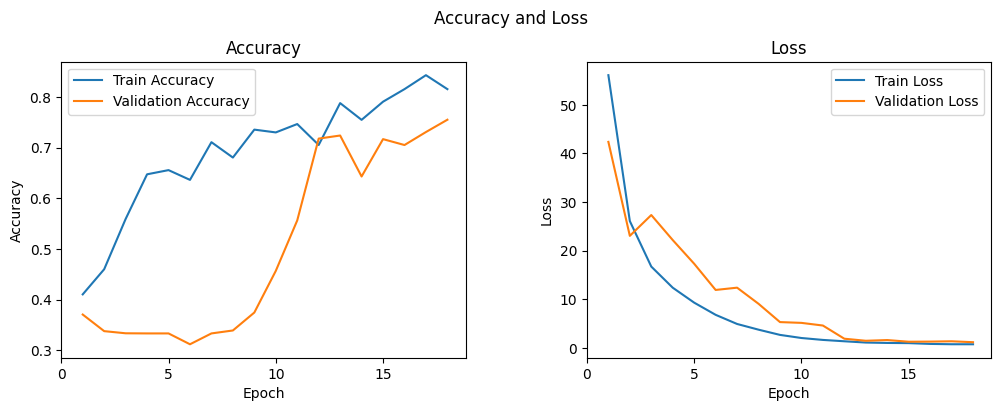

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.suptitle('Accuracy and Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = len(history.history['loss'])
epoch_list = list(range(1, epochs + 1))

acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

ax1.plot(epoch_list, history.history[acc_key], label='Train Accuracy')
ax1.plot(epoch_list, history.history[val_acc_key], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend(loc="best")

plt.show()


## Plot Confusion Matrix

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TEST_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    color_mode='rgb',
    shuffle=False,
)


Found 300 images belonging to 3 classes.


In [ ]:
import numpy as np

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict(test_generator, steps = nb_samples)
y_pred = np.rint(predictions)
y_pred = tf.argmax(y_pred, axis=1)

y_true = test_generator.classes

300/300 ━━━━━━━━━━━━━━━━━━━━ 116s 353ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=60)
    plt.yticks(tick_marks, classes, fontsize=60)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=60)

    plt.ylabel('True label', fontsize=60)
    plt.xlabel('Predicted label', fontsize=60)

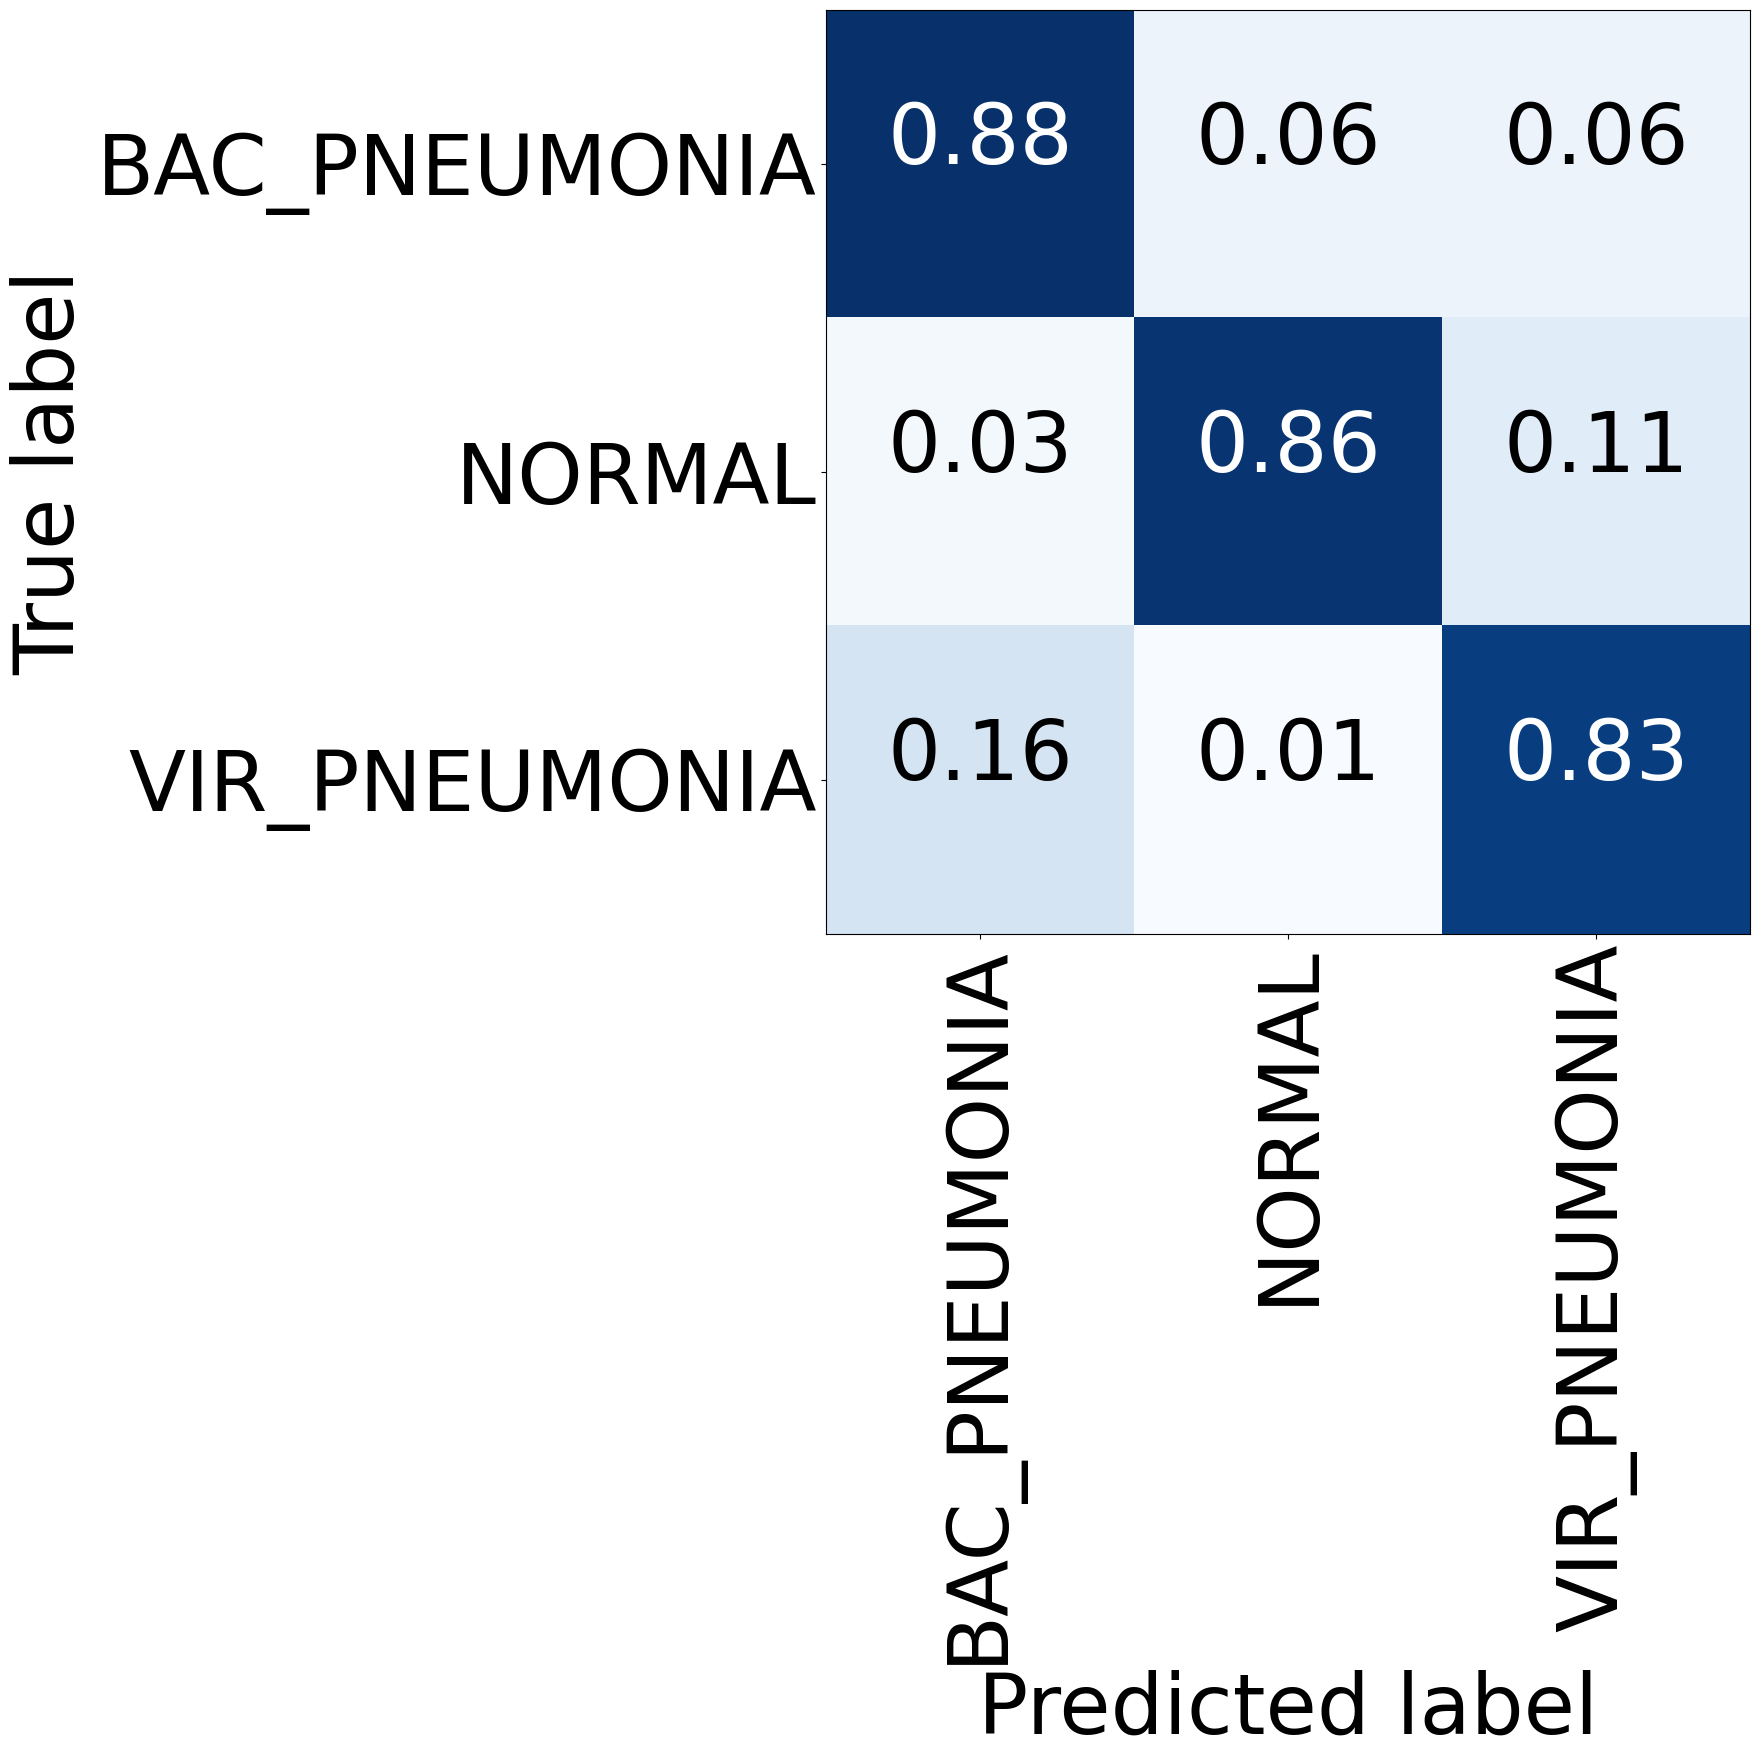

In [ ]:
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=test_generator.class_indices.keys(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.88      0.85       100
           1       0.92      0.86      0.89       100
           2       0.83      0.83      0.83       100

    accuracy                           0.86       300
   macro avg       0.86      0.86      0.86       300
weighted avg       0.86      0.86      0.86       300



In [ ]:
model.evaluate(test_generator)

300/300 ━━━━━━━━━━━━━━━━━━━━ 112s 372ms/step - acc: 0.8778 - auc: 0.9633 - loss: 0.6566 - precision: 0.8860 - recall: 0.8716


[0.6908426284790039,
 0.8585858345031738,
 0.8500000238418579,
 0.9583777785301208,
 0.8533333539962769]

## Save Model

In [ ]:
model.save("IR.keras")